In [20]:
import cv2
import torch
import numpy as np
from PIL import Image
from utils.DiffusionUtils import DiffusionUtils
from utils.TemplateManager import TemplateManager

from ptp.AttentionControls import AttentionStore
from ptp.ptp_utils import text2image_ldm_stable, view_images
from ptp.attn_utils import show_cross_attention

  0%|          | 0/25 [00:00<?, ?it/s]

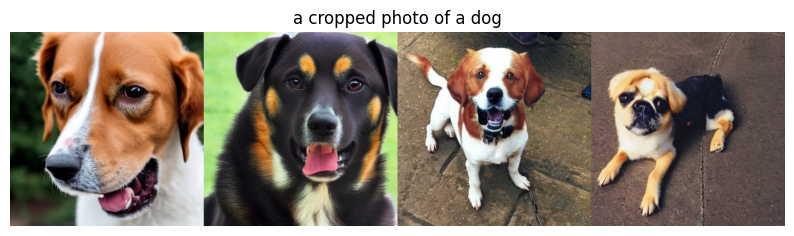

In [2]:
prompt_tmp = TemplateManager.get_random_template("IMG")
DiffusionUtils.run_prompt(prompt_tmp.format("dog"), 4)

In [3]:
concept_path = "/home/jack/Code/Research/instree_main/outputs/cat_sculpture/v0/learned_embeds.bin"
concepts = torch.load(concept_path)
DiffusionUtils.add_new_vocab('<*>', concepts['<*>'])
DiffusionUtils.add_new_vocab('<&>', concepts['<&>'])

New token added:  <*>
Current vocab size:  49409
All new tokens:  {'<*>': 49408}
New token added:  <&>
Current vocab size:  49410
All new tokens:  {'<*>': 49408, '<&>': 49409}


  0%|          | 0/25 [00:00<?, ?it/s]

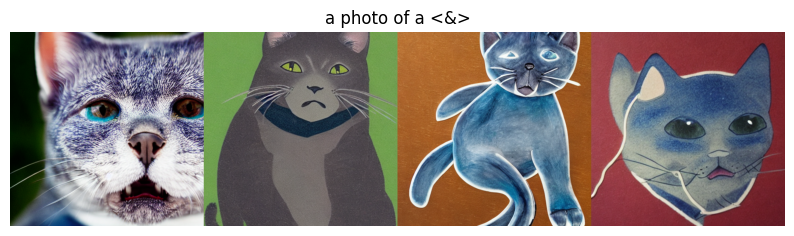

In [4]:
prompt_tmp = TemplateManager.get_random_template("IMG")
DiffusionUtils.run_prompt(prompt_tmp.format("<&>"), 4)

  0%|          | 0/26 [00:00<?, ?it/s]

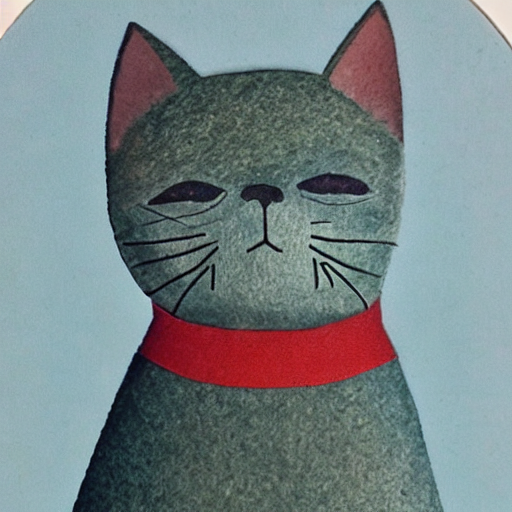

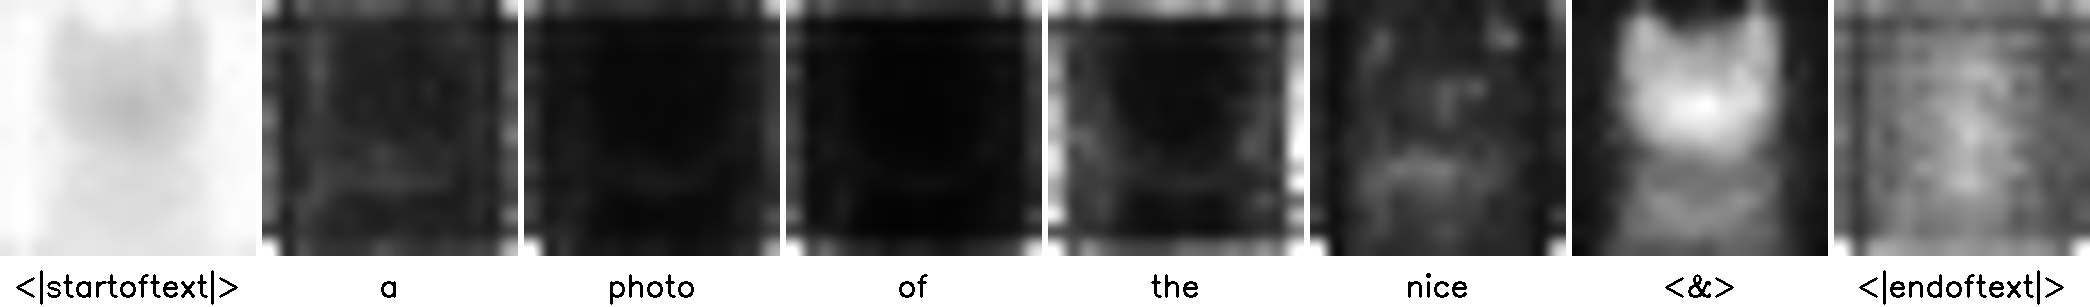

In [15]:
SEED = 42
torch.manual_seed(SEED)
controller = AttentionStore()
prompts = [TemplateManager.get_random_template("IMG").format("<&>")]

images, x_t = text2image_ldm_stable(
    DiffusionUtils.pipe, 
    prompts,
    controller, 
    latent=None, 
    num_inference_steps=25, guidance_scale=7.5, 
    generator=None, low_resource=False)
view_images(images)

attn_map = show_cross_attention(prompts, controller, res=16, from_where=("up", "down"))

In [ ]:
def otsu_thresholding(image: np.ndarray) -> np.ndarray:
    """
    Apply Otsu's thresholding to a color image by converting it to grayscale.
    Parameters: image (np.ndarray): Input color image of shape (H, W, C). 
    Returns: np.ndarray: Binary thresholded image.
    """
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return np.expand_dims(binary_image, axis=2)

def get_image_latent(img_path):
    image = Image.open(img_path).resize((512, 512))
    image = np.expand_dims(image, axis=0)
    image_latent = torch.tensor(DiffusionUtils.image2latent(image), dtype=torch.float16).to(DiffusionUtils.device)
    return image_latent

  0%|          | 0/1 [00:00<?, ?it/s]

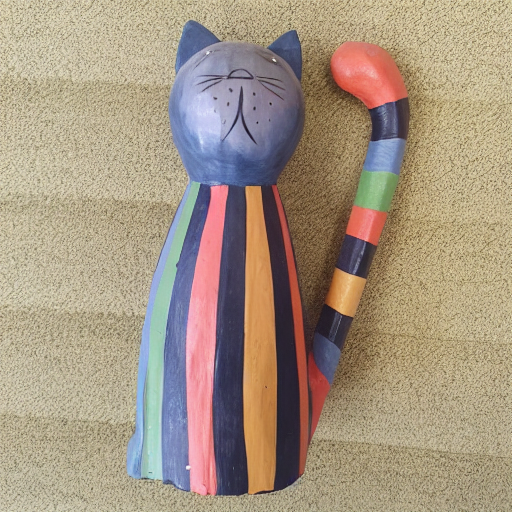

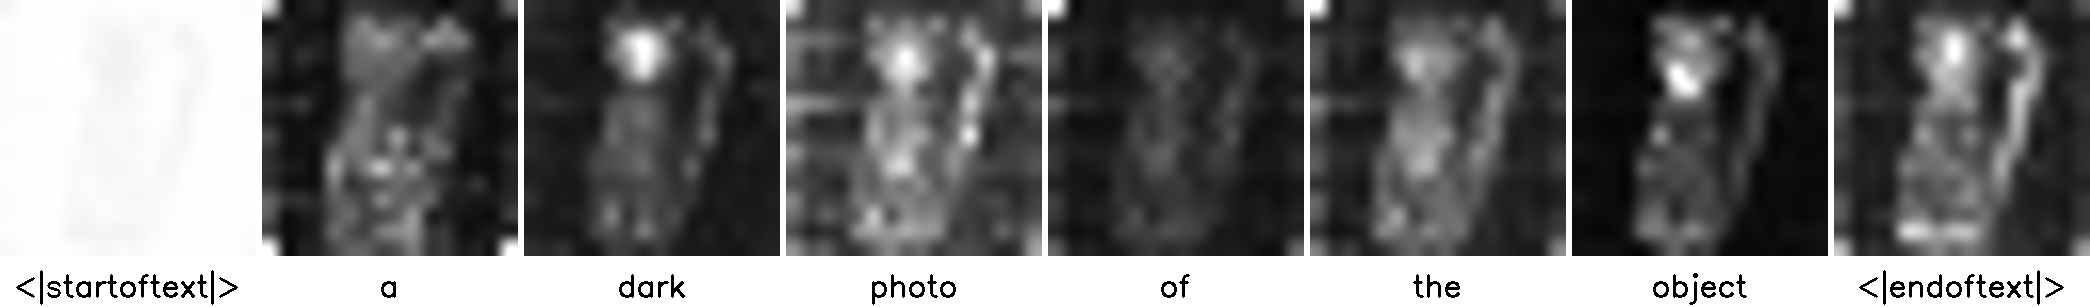

In [68]:
SEED = 42
torch.manual_seed(SEED)
controller = AttentionStore()
prompts = [TemplateManager.get_random_template("IMG").format("object")]


latent = get_image_latent("/home/jack/Code/Research/instree_main/input_concepts/cat_sculpture/v0/1.jpeg")

images, x_t = text2image_ldm_stable(
    DiffusionUtils.pipe, 
    prompts,
    controller, 
    latent=latent, 
    num_inference_steps=1, guidance_scale=7.5, 
    generator=None, low_resource=False)
view_images(images)

attn_map = show_cross_attention(prompts, controller, res=16, from_where=("up", "down"))

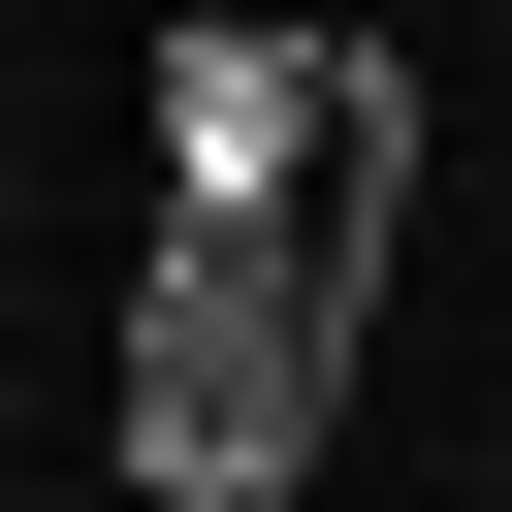

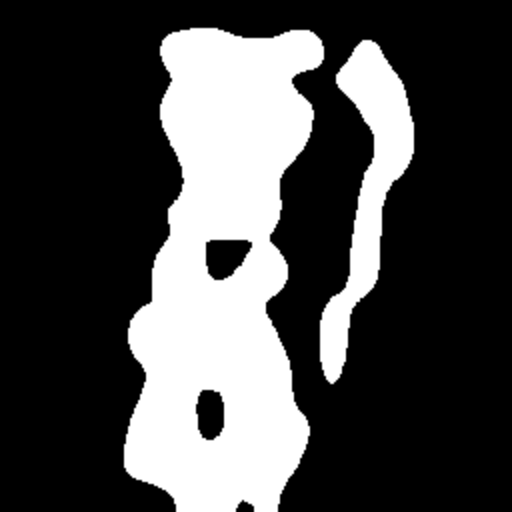

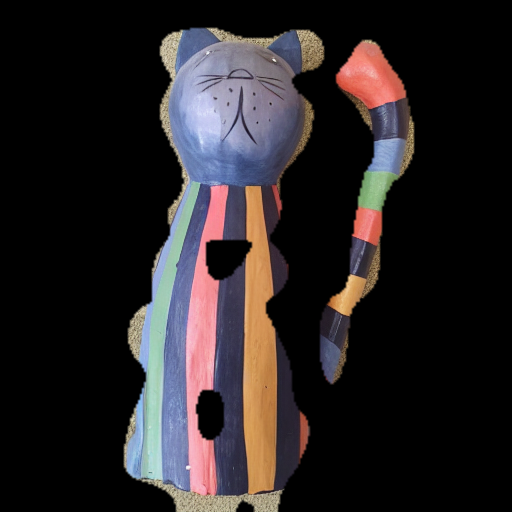

In [72]:
view_images(cv2.resize(attn_map[-2][:256], (512, 512)))
mask = otsu_thresholding((attn_map[-2][:256]))
mask = mask / 255
mask = cv2.resize(mask, (512, 512))
mask = np.expand_dims(mask, axis=2)
view_images(mask * 255)

# element wise multiplication 
# mask and original_image[0]

masked_image = mask * images[0]
view_images(masked_image)